In [145]:
import plotnine
from math import e
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy

%matplotlib inline

In [146]:

def grad_constant(M, alpha, phi, psi, t, y):
    """Returns a scaling vector, used to scale the inconsistent gradients' components
        \t M (float): max signal strength/ gas concentration
        \t alpha (float): max rate of change
        \t phi (float): horizontal shifter, time of midpoint/greatest rate of change
        \t psi (float): vertical shifter, baseline intensity/ gas concentration
        \t t (float): a point in the sampling points of data
        \t y (float): a point in the observed data
    """
    #print(2.0*(M/(1.0+e**(-1.0*alpha*(t-phi)))+psi-y))
    return (2.0*(M/(1.0+e**(-1.0*alpha*(t-phi)))+psi-y))

def grad_M(M, alpha, phi, psi, time, y_series):
    """Returns a scaling vector, used to scale the inconsistent gradients' components
        \t M (float): max signal strength/ gas concentration
        \t alpha (float): max rate of change
        \t phi (float): horizontal shifter, time of midpoint/greatest rate of change
        \t psi (float): vertical shifter, baseline intensity/ gas concentration
        \t t (iterable): the sampling points of data
        \t y_series (iterable): the observed data
    """
    buffer = 0.0
    for i, t in enumerate(time):
        y = y_series[i]
        buffer += (grad_constant(M, alpha, phi, psi, t, y)/(1.0+e**(alpha*(phi-t))))/len(time)
    return buffer

def grad_alpha(M, alpha, phi, psi, time, y_series):
    buffer = 0.0
    for i, t in enumerate(time):
        y = y_series[i]    
        buffer += (grad_constant(M, alpha, phi, psi, t, y)*M*((t-phi)*e**(alpha*(phi-t)))
                    /((1+e**(alpha*(phi-t)))**2.0))/len(time)
    return buffer

def grad_phi(M, alpha, phi, psi, time, y_series):
    buffer = 0.0
    for i, t in enumerate(time):
        y = y_series[i]    
        buffer += (grad_constant(M, alpha, phi, psi, t, y)*-1.0*alpha*M*e**(alpha*(phi-t))
             /(1+e**(alpha*(phi-t)))**2.0)/len(time)
    return buffer

def grad_psi(M, alpha, phi, psi, time, y_series):
    buffer = 0.0
    for i, t in enumerate(time):
        y = y_series[i]
        buffer += grad_constant(M, alpha, phi, psi, t, y)/len(time)
    return buffer

In [147]:
def get_cost(M, alpha, phi, psi, time, y_series):
    buffer = 0.0
    for i, t in enumerate(time):
         buffer += (M/(1.0+e**(alpha*(phi-t)))+psi - y_series[i])        
    return buffer

In [162]:
def gradient_descent(init_4D_point, time, y_series, descent_speed = .1, epochs = 10,):
    """
        Simple gradient descent
        init_4D_point (tuple) = (M, alpha, phi, psi)
        y (numpy array) = observed data
        t (numpy array) = sampling points for data
        descent speed (float) = step size
        epochs (int) = # of steps, if -1 then gradient descent will loop until minima is found
    """
    curr_M = init_4D_point[0]
    curr_alpha = init_4D_point[1]
    curr_phi = init_4D_point[2]
    curr_psi = init_4D_point[3]
    
    prev_M = 0.0
    prev_alpha = 0.0
    prev_phi = 0.0
    prev_psi = 0.0
    
#     minima_reached = False
    minima = ()
    iteration = 0
    
    for i in range(10000):
        prev_M = float(curr_M)
        prev_alpha = float(curr_alpha)
        prev_phi = float(curr_phi)
        prev_psi = float(curr_psi)
        
        curr_M -= (grad_M(curr_M, curr_alpha, curr_phi, curr_psi, time, y_series) * descent_speed)
        curr_alpha -= (grad_alpha(curr_M, curr_alpha, curr_phi, curr_psi, time, y_series) * descent_speed)
        curr_phi -= (grad_phi(curr_M, curr_alpha, curr_phi, curr_psi, time, y_series) * descent_speed)
        curr_psi -= (grad_psi(curr_M, curr_alpha, curr_phi, curr_psi, time, y_series) * descent_speed)
        
        iteration += 1
        
        if(get_cost(prev_M, prev_alpha, prev_phi, prev_psi, time, y_series)<
           get_cost(curr_M, curr_alpha, curr_phi, curr_psi, time, y_series)):
            minima_reached = True
            minima = (prev_M, prev_alpha, prev_phi, prev_psi)
            
    
    return minima


4.000000002032367


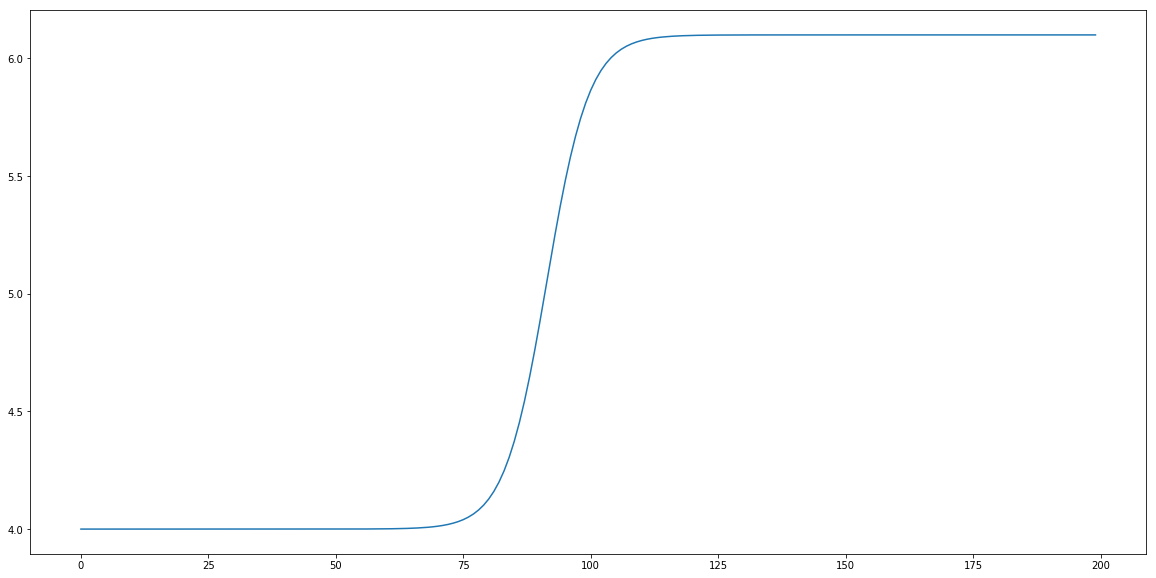

In [163]:
sample_x = np.linspace(0, 100, 200)
sample_y = []

for i, data in enumerate(sample_x):
    sample_y.append(2.10/(1+e**(-.4782*(data - 45.917)))+4)

print(sample_y[5])

plt.figure(figsize=(20,10))
plt.plot(sample_y)


In [164]:
descended_tuple = gradient_descent((2.01,.451,42.115,3),sample_x, sample_y)
print(descended_tuple)

(2.1000488508034447, 0.4781704224239537, 45.90598648501191, 3.999742827851892)


In [165]:
def logistic_curve(constant_tuple, time):
    out_y = []
    for i, data in enumerate(time):
        out_y.append(constant_tuple[0]/(1+e**(-1*constant_tuple[1]*(data - constant_tuple[2])))+constant_tuple[3])
    return out_y

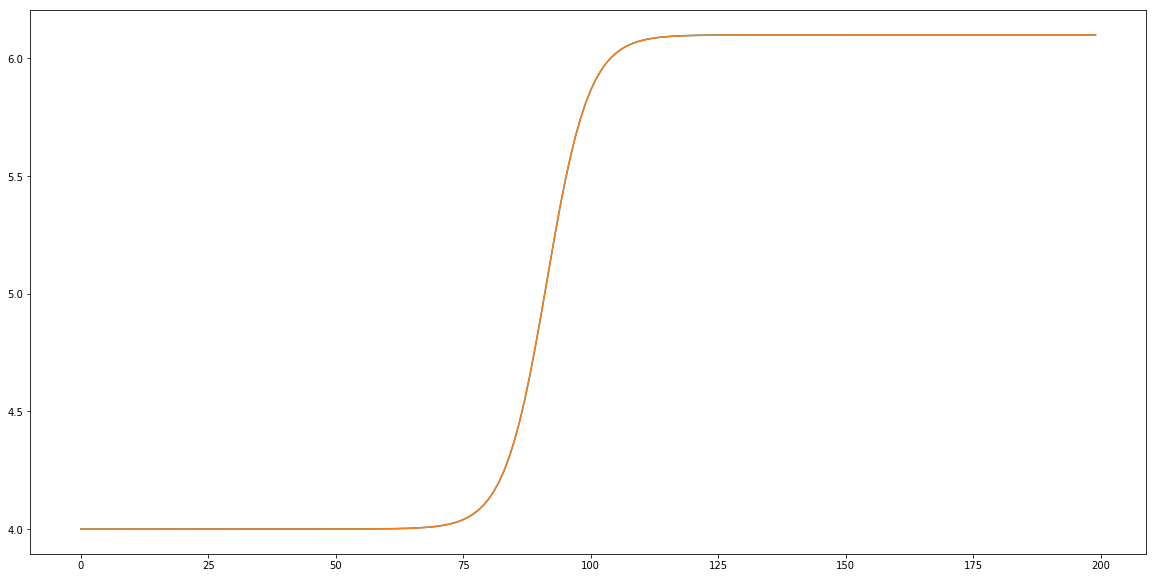

In [166]:
compare_curve = logistic_curve(descended_tuple, sample_x)
plt.figure(figsize = (20,10))
plt.plot(sample_y)
plt.plot(compare_curve)
plt.show()